In [ ]:
!pip install wordcloud

     |████████████████████████████████| 159 kB 7.9 MB/s eta 0:00:01


In [ ]:
!pip install -U spacy

In [1]:
#imports
import csv

#data manipulation
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#text packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import spacy
from bs4 import BeautifulSoup

#model preparation & selection 
from sklearn.model_selection import validation_curve, train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")


## Import Data

In [2]:
#text_data = pd.read_csv('IMDBdata.csv',engine='python',on_bad_lines='skip')
text_data = pd.read_csv('IMDBdata.csv',header=0)
print(text_data.shape)
text_data.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Removing HTML 

In [3]:
def remove_html(data):
    soup = BeautifulSoup(data, 'html.parser')
    return soup.get_text()

In [4]:
text_data['review'] = text_data['review'].apply(remove_html)
text_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Exploratory Data Analysis

In [5]:
#Using sklearn's Count Vectorizer to calculate frequencies for a WordCloud

stop = STOPWORDS

in_consistent_stopping = ['br','aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn']

for i in in_consistent_stopping:
  stop.add(i)

cv = CountVectorizer(min_df = 10, stop_words=stop)

X = cv.fit_transform(text_data['review'])

X_todict = X.toarray().sum(axis=0)

features = cv.get_feature_names_out()

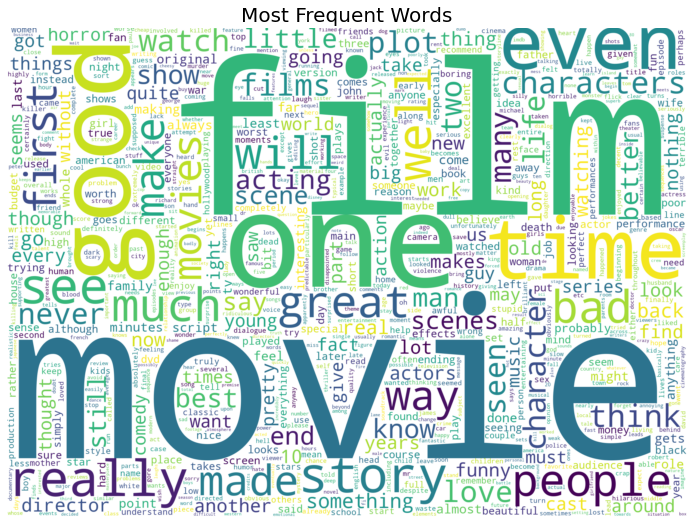

In [11]:
#Creating a dictionary of word frequencies to generate the Word Cloud

word_frequency = {features[i]:X_todict[i] for i in range(len(features))}

sorted_freq = {k: v for k, v in sorted(word_frequency.items(), key=lambda item: item[1], reverse=True)}

wordcloud = WordCloud(width=2500,height=1800, 
                      max_words=800,
                      stopwords = stop,
                      background_color='white',collocations=False,
                      normalize_plurals=False).generate_from_frequencies(sorted_freq)
plt.figure(figsize=(18,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Frequent Words',fontsize=20)
plt.show()

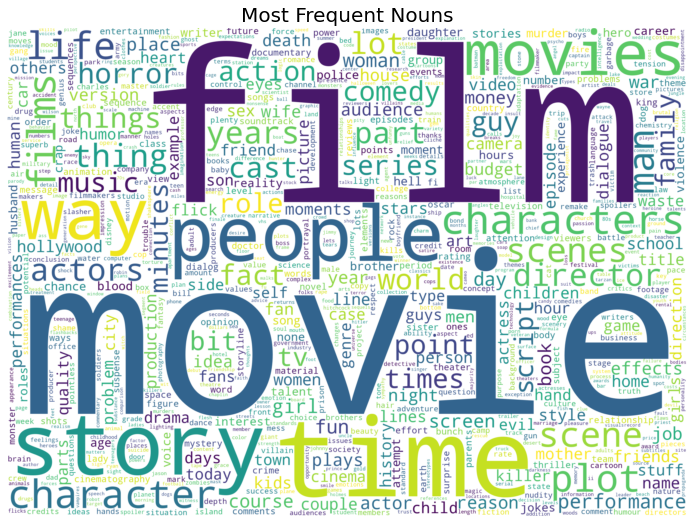

In [12]:
nlp = spacy.load("en_core_web_sm")

nouns_only = {}
counter = 0
for word, freq in sorted_freq.items():
  if counter > 800:   #wordcloud only has 800 words max
    break
  for token in nlp(word):
    if token.pos_ == 'NOUN':
      nouns_only[word]=freq
      counter +=1

wordcloud_noun = WordCloud(width=2500,height=1800, 
                      max_words=800,
                      stopwords = stop,
                      background_color='white',collocations=False,
                      normalize_plurals=False).generate_from_frequencies(nouns_only)
plt.figure(figsize=(18,9))
plt.imshow(wordcloud_noun, interpolation='bilinear')
plt.axis("off")
plt.title('Most Frequent Nouns',fontsize=20)
plt.show()

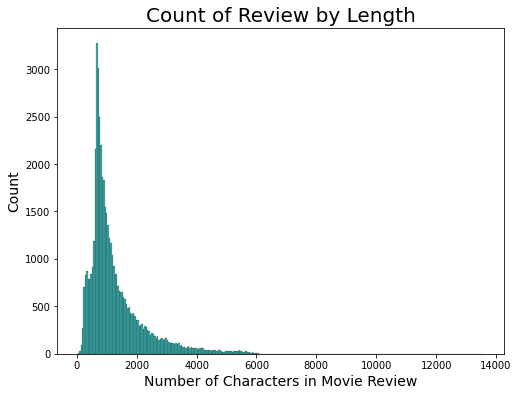

In [6]:
new_data_df = text_data.copy()

new_data_df['Text_Length'] = new_data_df['review'].str.len()

plt.figure(figsize=(8,6))
ax = sns.histplot(x=new_data_df['Text_Length'],color='darkcyan')
plt.ylabel('Count',fontsize=14)
plt.xlabel('Number of Characters in Movie Review',fontsize=14)
plt.title('Count of Review by Length',fontsize=20)
plt.show()

Majority of our data is between 0 and 2000 characters

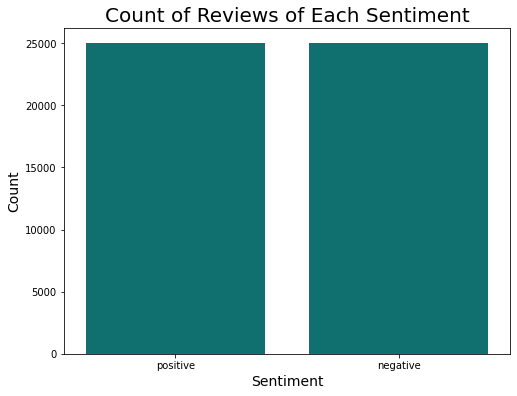

In [8]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x=new_data_df['sentiment'], color='teal')
#plt.xlim(0,12000)
plt.ylabel('Count',fontsize=14)
plt.xlabel('Sentiment',fontsize=14)
plt.title('Count of Reviews of Each Sentiment',fontsize=20)
plt.show()

In [9]:
print('There are '+ str(text_data[text_data['sentiment']=='positive'].shape[0])+' positive reviews.')
print('There are '+ str(text_data[text_data['sentiment']=='negative'].shape[0]) + ' negative reviews.')

There are 25000 positive reviews.
There are 25000 negative reviews.


We can also see there is no class imbalance here.

##Data Preparation

In [7]:
vec = TfidfVectorizer(stop_words='english', min_df=7, ngram_range = (1,2), max_df = 0.8)
X_data = vec.fit_transform(text_data['review'])
new_data_df['sentiment_score'] = np.where(new_data_df['sentiment']=='positive',1,0)
Y_data = new_data_df['sentiment_score']

Xtrain,Xtest,Ytrain,Ytest = train_test_split(X_data, Y_data, test_size=0.15, random_state=0)

## Modeling

First, we define a function that we'll use to plot the results of cross validation

In [8]:
def plot_val_curve(param_range, 
                   train_score, 
                   test_score, 
                   param_name: str, 
                   est_name: str, 
                   scoring: str):
  '''
  plot_val_curve function takes in the train and test scores from the validation_curve object and plots the validation curve

  Parameters:
    param_range: (array or list object) parameter values tested with the cross validation curve
    train_score: (array or list object) training score results from validation curve
    test_score: (array or list object) validation score results from validation curve
    param_name: (str) hyper-parameter name that is being manipulated
    est_name: (str) name of estimator
    scoring: (str) name of scoring type

  Returns:
    best_param: (float) the best parameter found by validation_curve (characterized by having the best F1 score)

  Prints:
    best_param: (float) the best parameter found by validation_curve (characterized by having the best F1 score)
    Plots the validation curve
  '''
  train_scores_mean = np.mean(train_score, axis=1)
  train_scores_std = np.std(train_score, axis=1)
  test_scores_mean = np.mean(test_score, axis=1)
  test_scores_std = np.std(test_score, axis=1)

  print('The best ' + str(param_name)+ ' is ' + str(param_range[np.argmax(test_scores_mean)]))

  #Plot CV error as a function of C
  lw = 2
  plt.figure(figsize=(10,6))
  plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkgreen", lw=lw)
  plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="mediumaquamarine", lw=lw)

  a_title = 'Validation Curve with '
  a_title += est_name
  plt.title(a_title)
  plt.xlabel(str(param_name))
  labels = [str(i) for i in param_range]
  plt.xticks(ticks=param_range,labels=labels)
  plt.ylabel(scoring)
  plt.legend(loc="best")
  plt.show()

  return param_range[np.argmax(test_scores_mean)]

In [ ]:
#Logistic Regression (Scored by F1)

logr = LogisticRegression(max_iter=5000)
param_range = np.logspace(-4, 5, 18)

train_scores, test_scores = validation_curve(
    logr, X_data, Y_data, param_name="C", param_range=param_range,
    scoring='f1_weighted', n_jobs=1)

#Logistic Regression (Scored by Accuracy)

logr2 = LogisticRegression(max_iter=5000)

train_scores2, test_scores2 = validation_curve(
    logr2, X_data, Y_data, param_name="C", param_range=param_range,
    scoring='accuracy', n_jobs=1)

The best C is 5.817091329374358


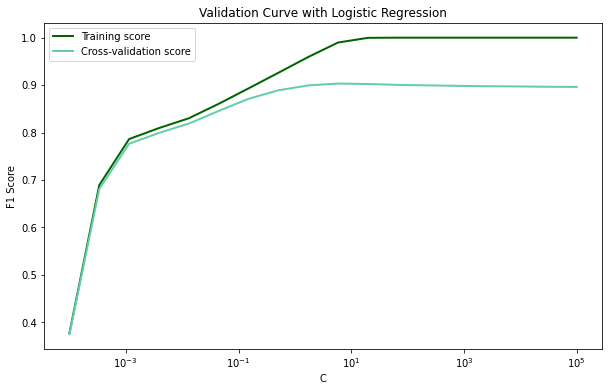

In [ ]:
l1 = plot_val_curve(param_range, train_scores, test_scores, 'C', 'Logistic Regression','F1 Score')

The best C is 5.817091329374358


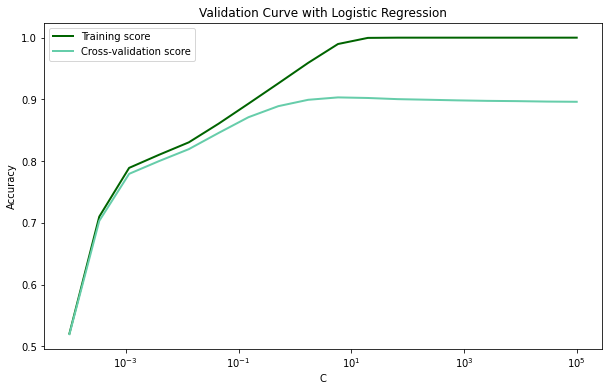

In [ ]:
l2 = plot_val_curve(param_range, train_scores2, test_scores2, 'C', 'Logistic Regression','Accuracy')

In [ ]:
print('The best value for C is '+str(l1)+' based on F1 score')

logr_best = LogisticRegression(C=l1, max_iter=5000).fit(Xtrain,Ytrain)
logr_score = logr_best.score(Xtest,Ytest)
print('The accuracy for the best Log Reg model is '+str(logr_score))
logr_f1score = f1_score(Ytest, logr_best.predict(Xtest))
print('The F1 for the best Log Reg model is '+str(logr_f1score))


The best value for C is 5.817091329374358 based on F1 score
The accuracy for the best Log Reg model is 0.9032
The F1 for the best Log Reg model is 0.9026287553648069


We can see the accuracy versus F1 scoring didn't make much of a difference. We can assume this is because there is no class imbalance, so we can try the same cross-validation with other models (using accuracy as the scoring measure). Next, we try KNN, and we cross-validate to pick the value for K.

In [19]:
#K Nearest Neighbors w/ uniform weights

param_range_n = np.arange(12, 34, 4)

knn = KNeighborsClassifier(weights='uniform')

train_scores_knn, test_scores_knn = validation_curve(
    knn, X_data, Y_data, param_name="n_neighbors", param_range=param_range_n,
    scoring='accuracy', n_jobs=1)

The best n_neighbors is 32


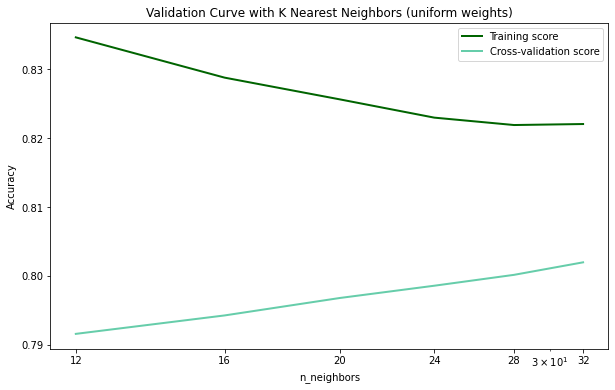

In [27]:
k1 = plot_val_curve(param_range_n, train_scores_knn, test_scores_knn, 'n_neighbors', 'K Nearest Neighbors (uniform weights)','Accuracy')

In [23]:
print('The best value for number of neighbors is '+str(k1)+' for KNN with uniform weights')

best_knn_uni = KNeighborsClassifier(n_neighbors=k1,weights='uniform').fit(Xtrain,Ytrain)
knn_uni_score = best_knn_uni.score(Xtest,Ytest)
print('The accuracy for the best KNN model (with uniform weights) is '+str(knn_uni_score))
knn_uni_f1score = f1_score(Ytest, best_knn_uni.predict(Xtest))
print('The F1 for the best KNN model (with uniform weights) is '+str(knn_uni_f1score))

The best value for number of neighbors is 32 for KNN with uniform weights
The accuracy for the best KNN model (with uniform weights) is 0.8037333333333333
The F1 for the best KNN model (with uniform weights) is 0.8089304257528557


In [28]:
#K Nearest Neighbors w/ distance weights

knn2 = KNeighborsClassifier(weights='distance')

train_scores_knn2, test_scores_knn2 = validation_curve(
    knn2, X_data, Y_data, param_name="n_neighbors", param_range=param_range_n,
    scoring='accuracy', n_jobs=1)

The best n_neighbors is 32


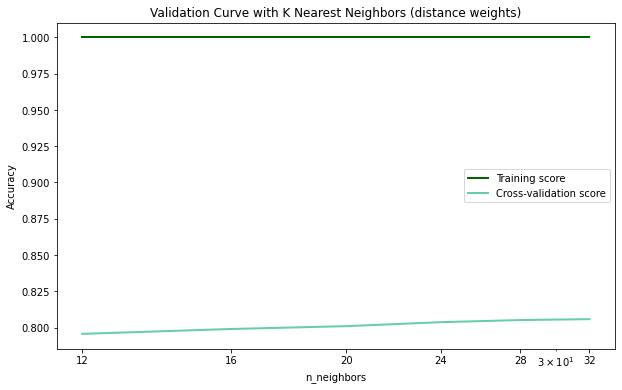

In [30]:
k2 = plot_val_curve(param_range_n, train_scores_knn2, test_scores_knn2, 'n_neighbors', 'K Nearest Neighbors (distance weights)','Accuracy')

In [31]:
print('The best value for number of neighbors is '+str(k2)+' for KNN with distance weights')

best_knn_dist = KNeighborsClassifier(n_neighbors=k2,weights='distance').fit(Xtrain,Ytrain)
knn_dist_score = best_knn_dist.score(Xtest,Ytest)
print('The accuracy for the best KNN model (with distance weights) is '+str(knn_dist_score))
knn_dist_f1score = f1_score(Ytest, best_knn_dist.predict(Xtest))
print('The F1 for the best KNN model (with distance weights) is '+str(knn_dist_f1score))

The best value for number of neightbors is 32 for KNN with distance weights
The accuracy for the best KNN model (with distance weights) is 0.8048
The F1 for the best KNN model (with distance weights) is 0.8138825324180015


In [12]:
#Support Vector Machine (not cross-validating here)

svc_lin = LinearSVC().fit(Xtrain,Ytrain)
svc_lin_score = svc_lin.score(Xtest,Ytest)
print('The accuracy for the Linear SVC model is '+str(svc_lin_score))
svc_lin_f1score = f1_score(Ytest, svc_lin.predict(Xtest))
print('The F1 for the Linear SVC model is '+str(svc_lin_f1score))

The accuracy for the Linear SVC model is 0.8997333333333334
The F1 for the Linear SVC model is 0.8994114499732476


Logistic regression achieves the highest accuracy and F1 score, so this is our estimator of choice.